## Community State Type Analysis

This notebook contains the steps to perform hierarchical clustering and derive community state type information for the VMET cohort.

In [1]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial import distance
from sklearn.metrics import silhouette_samples
import matplotlib.ticker as ticker
from CST_Clustering import cluster16SMatrix, validateClusters

The hierarchical clustering will be performed on the data matrix with counts aggregated per species (sum of all OTUs for a given species). This file was generated separately with the *aggregateOTUs.py* script.

In [2]:
# Read the 16S count data matrix
counts_species = pds.read_csv('../../Data/16S Data/VMET_16S_SpeciesMatrixFiltered.csv')

# Study clinical and demographic data
vmetMetadata = pds.read_csv('../../Data/VMET_Metadata.csv')

counts_species = vmetMetadata.merge(counts_species, left_on='Seq_ID', right_on='Seq_ID')
# Select only the columns containing counts. The index starts at 20
counts_matrix = counts_species.iloc[:, 20::]

counts_matrix.index = counts_species['Seq_ID'].values
counts_matrix.index = counts_matrix.index.set_names('Seq_ID')

# Selecting the number of clusters - CST's

In the next cell, the "optimal" number of clusters is estimated using the silhouette score. 
The validateClusters function is defined separately in the *CST_Clustering.py* file.

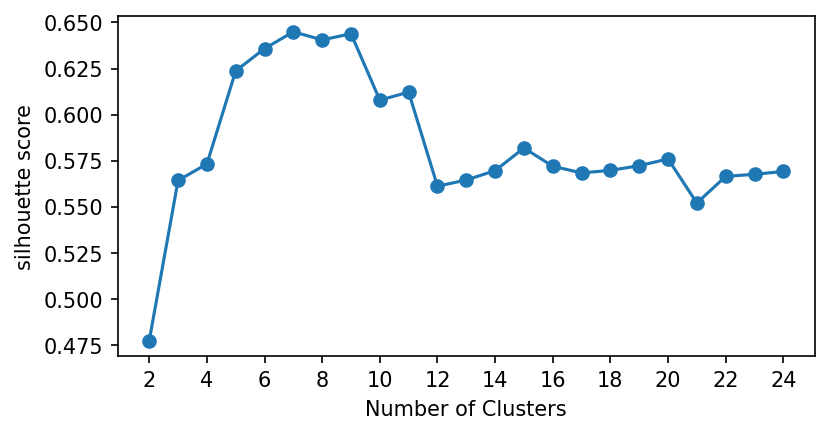

The suggested number of clusters is 7


In [3]:
cluster_validation = validateClusters(counts_matrix, distanceMetric='jensenshannon', clusterMethod='ward', method='silhouette')
fig, ax = plt.subplots(dpi=150, figsize=(6, 3))
ax.plot(cluster_validation[0], cluster_validation[1], '-o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("{0} score".format(cluster_validation[2]))

fig.savefig('./Analysis Figures/VMET_16S_SilhouetteValidation.png')
# fig.savefig('./Analysis Figures/VMET_16S_SilhouetteValidation.eps')
plt.show()
print("The suggested number of clusters is {0}".format(cluster_validation[0][np.argmax(cluster_validation[1])]))

## Perform the Clustering of the CLR transformed 16S data matrix

Vaginal Community State types are obtained by performing Ward hierarchical clustering and using Jensen-Shannon divergence as distance metric.

Based on the silhouette score optimization performed on the previous cell, we select 7 clusters.

In [4]:
CST_Clustering = cluster16SMatrix(counts_matrix, nClusters=7, distanceMetric='jensenshannon', clusterMethod='ward')

### Heatmap plot with the clustering dendrogram

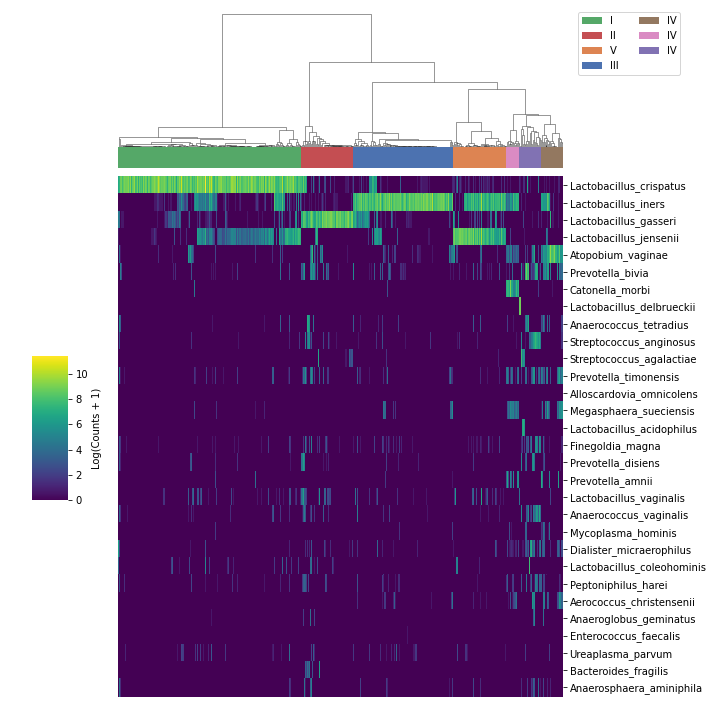

In [26]:
nCST = len(CST_Clustering['clusterID'].unique())
cmap = ListedColormap(sns.color_palette("deep", nCST))

row_colors = CST_Clustering['clusterID'].map(cmap)


cstMap = sns.clustermap(np.log(counts_matrix.values[:, 0:30].T + 1), col_linkage=CST_Clustering['LinkageMatrix'], 
                        row_cluster=False, yticklabels=counts_matrix.columns[0:30], 
                        col_colors=row_colors.values, cmap='viridis', xticklabels=False)

bottom, top = cstMap.ax_heatmap.get_ylim()
cstMap.ax_heatmap.set_ylim(bottom + 0.5, top - 0.5)

# the 
cst_string_decode_classic = {1:'V', 0:'III', 2:'I', 3:'II', 4:'IV', 
                     5:'IV', 
                     6:'IV'}


cst_string_decode = {1:'V', 0:'III', 2:'I', 3:'II', 4:'IV', 
                     5:'IV', 
                     6:'IV'}

for label in [2, 3, 1, 0, 5, 6, 4]:
#for label in [2, 3, 1, 0, 5]:
    cstMap.ax_col_dendrogram.bar(0, 20, color=cmap(label), label=cst_string_decode[label], linewidth=0)

cstMap.ax_col_dendrogram.legend(bbox_to_anchor=(1.15, 1), loc='upper center', ncol=2)

# Adjust the postion of the main colorbar for the heatmap
cstMap.cax.set_position([0.05, .3, 0.05, .2])
cstMap.cax.set_ylabel('Log(Counts + 1)')

# Change for desired format.
cstMap.savefig('./Analysis Figures/VMET_16S_CSTClustering.png', dpi=300)
#cstMap.savefig('./Analysis Figures/VMET_16S_CSTClustering.eps', dpi=300)
#cstMap.savefig('./Analysis Figures/VMET_16S_CSTClustering.svg', dpi=300)

plt.show()

To inspect the characteristic microbial composition of each cluster, we plot the mean relative abundances of the top 6 species per CST cluster.

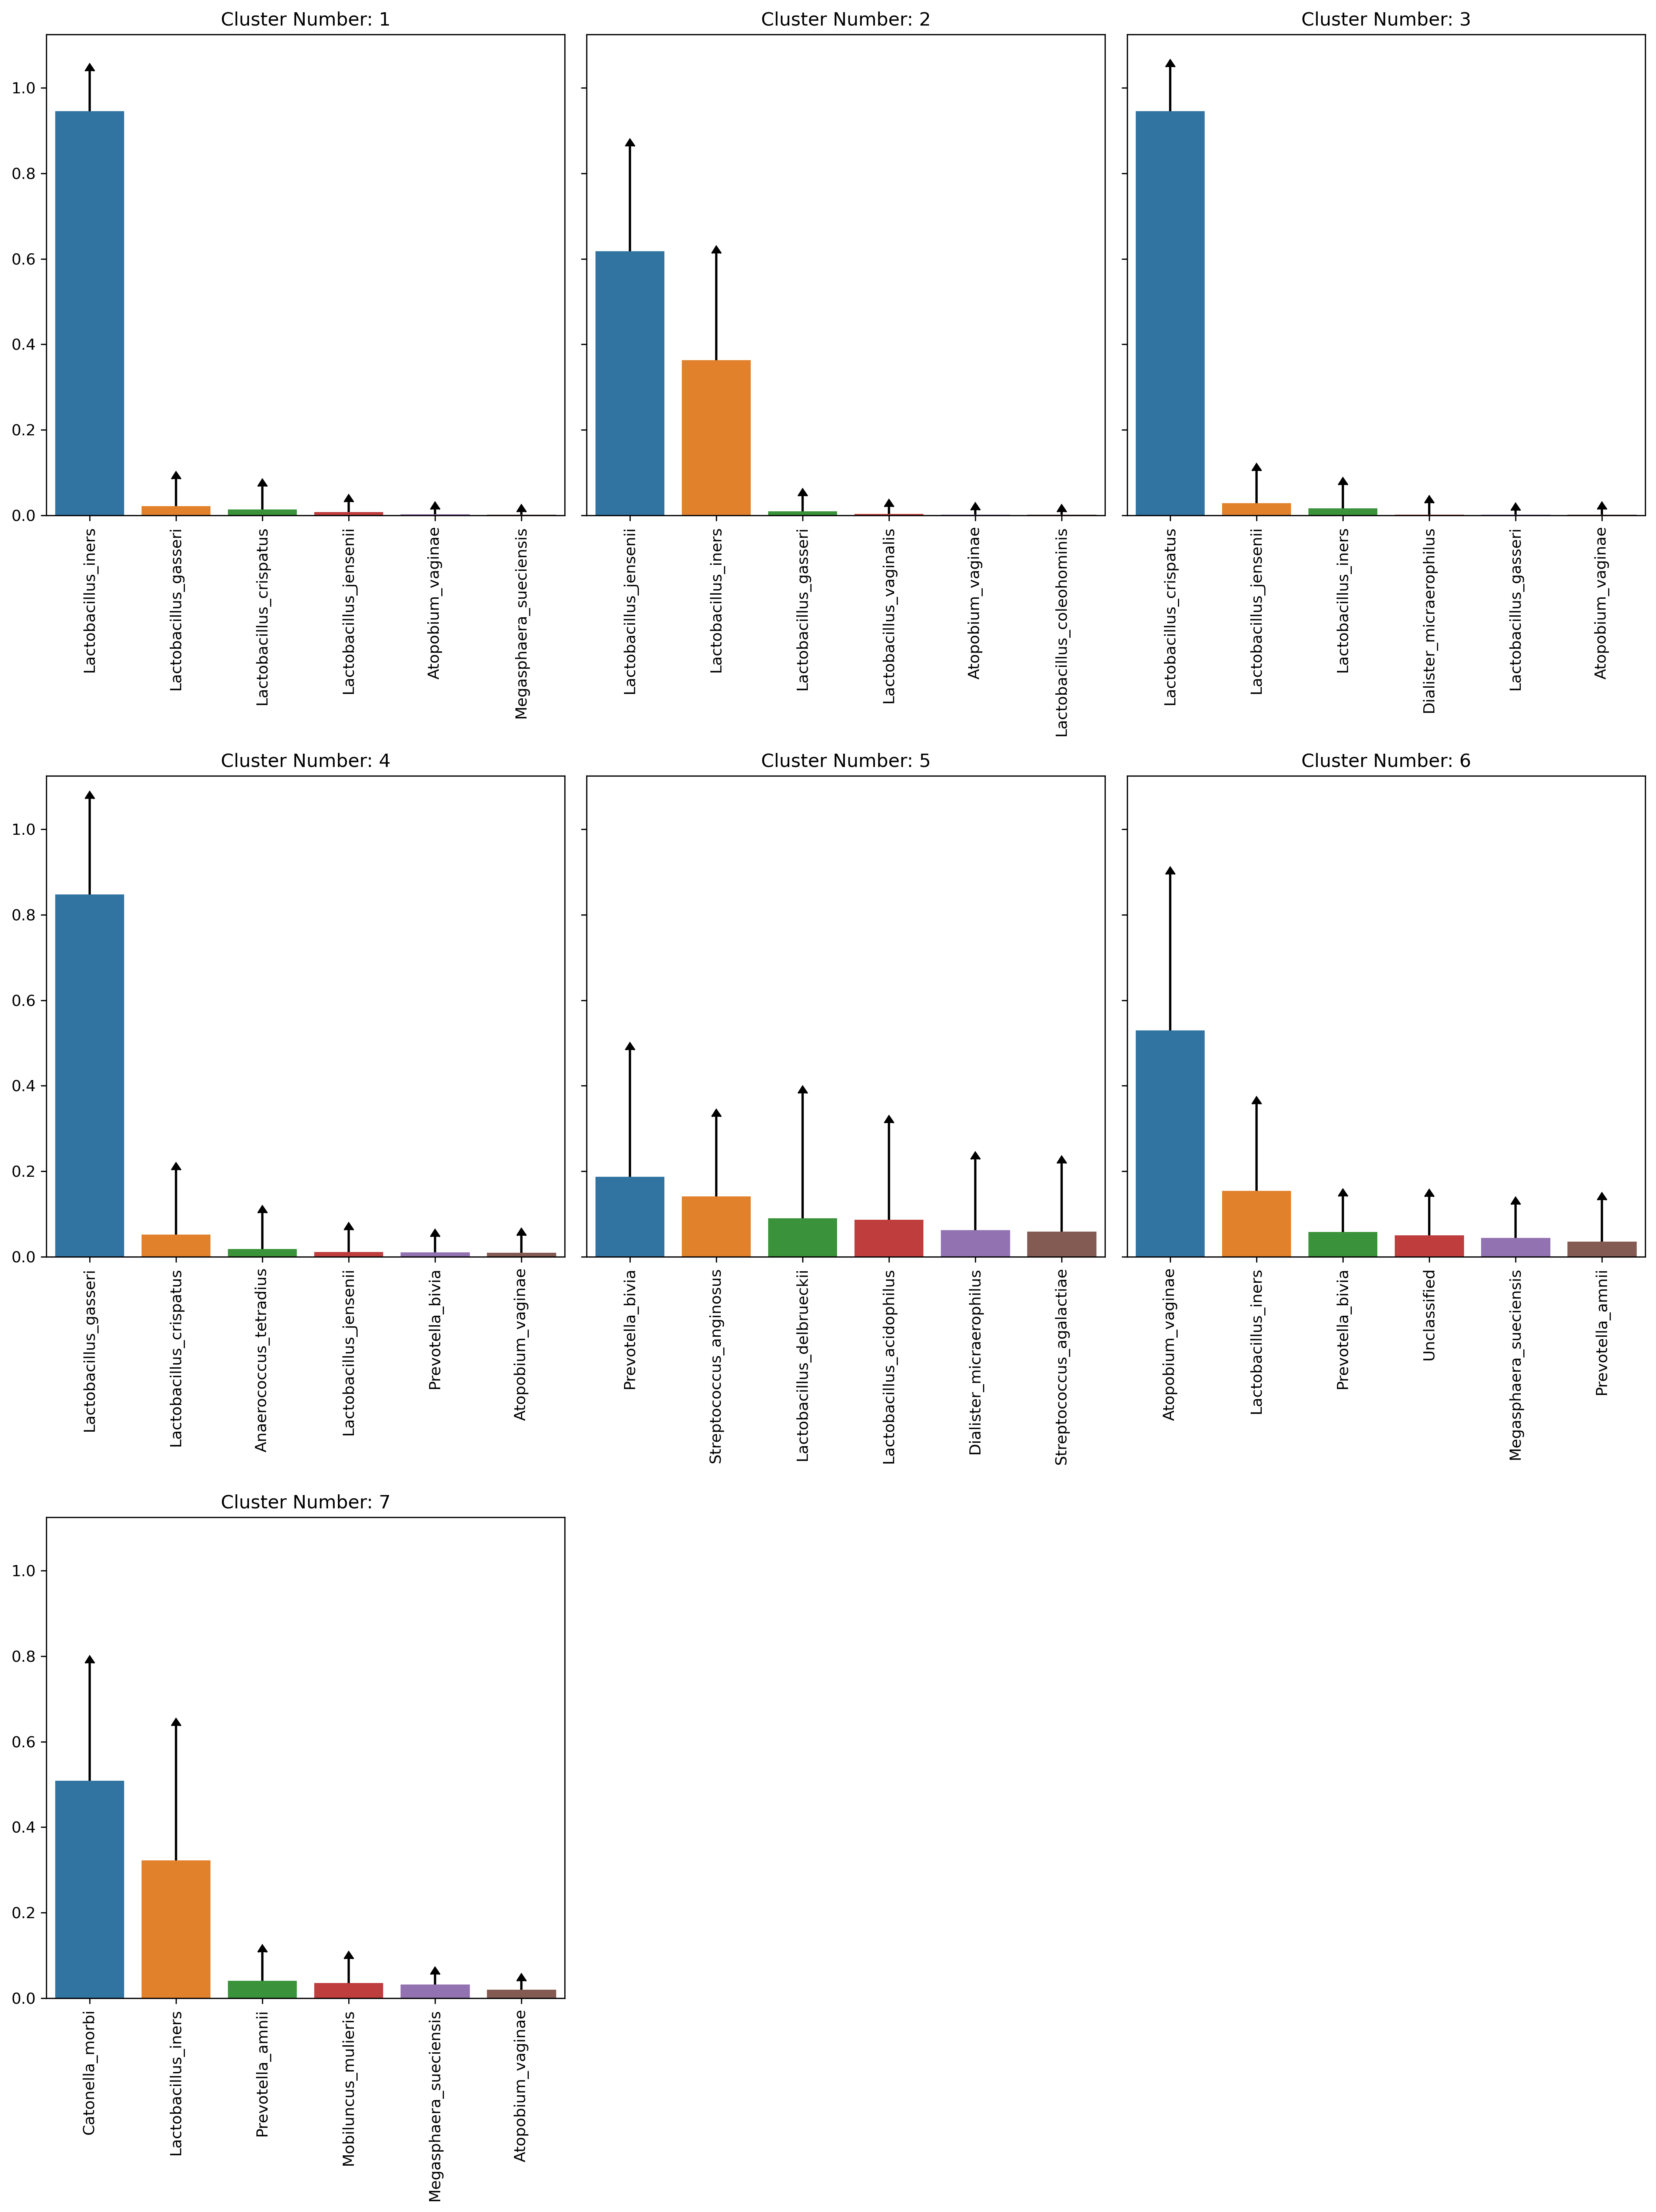

In [27]:
fig, ax = plt.subplots(3, 3, dpi=300, figsize=(15,20), sharey=True)
fig.delaxes(ax[2, 1])
fig.delaxes(ax[2, 2])

for idx, cst in enumerate(CST_Clustering['ClusterAbundances']):
    
    sns.barplot(x=np.arange(0, 6), y=cst[1][0:6], **{'yerr':cst[2][0:6], 'error_kw':{'lolims':True}}, ax=ax[int(np.floor(idx / 3)), idx % 3])
    ax[int(np.floor(idx / 3)), idx % 3].set_xticklabels(cst[1][0:6].index, rotation='vertical', fontsize=10)
    ax[int(np.floor(idx / 3)), idx % 3].set_title("Cluster Number: {0}".format(str(cst[0] + 1)))

fig.tight_layout()

fig.savefig('./Analysis Figures/VMET_16S_CSTClustering_SpeciesDescription.png')
# fig.savefig('./Analysis Figures/VMET_16S_CSTClustering_SpeciesDescription.eps')

### Assess the silhouette values for samples accross the 7 CST clusters

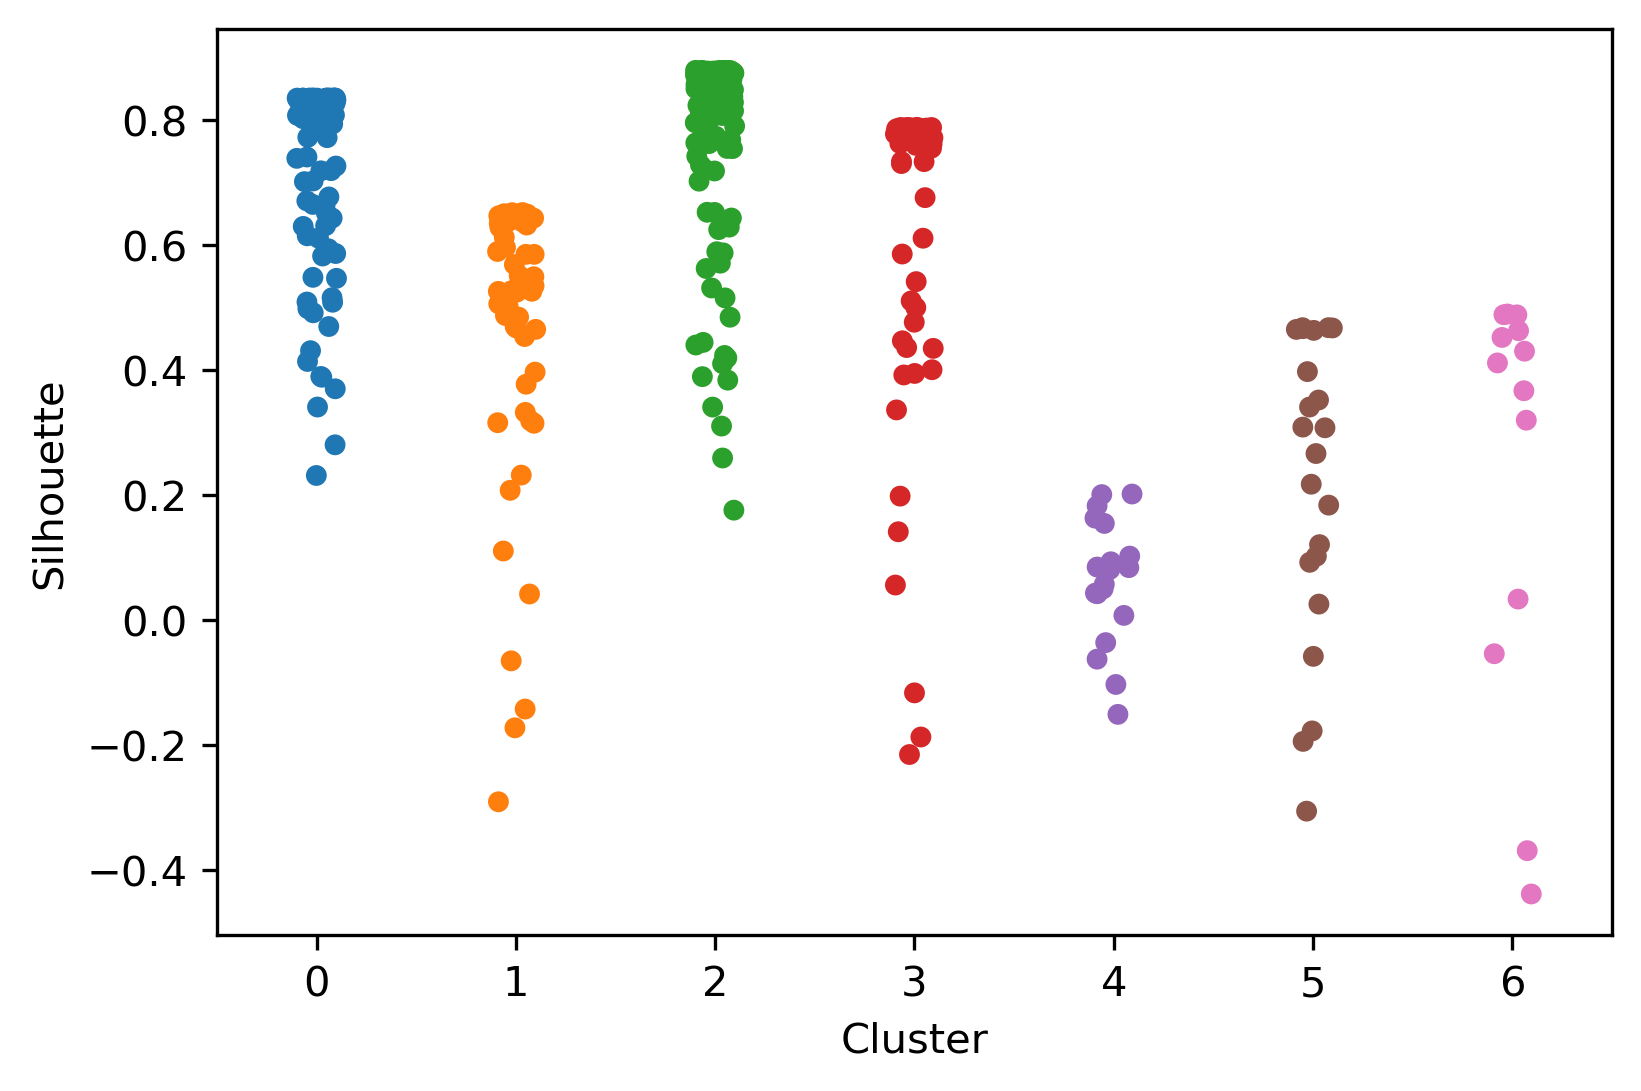

In [30]:
silhFrame = pds.DataFrame({'Cluster':CST_Clustering['clusterID'], 'Silhouette':CST_Clustering['SilhouetteSamples']})

fig, ax = plt.subplots(dpi=300)
sns.stripplot(data=silhFrame, x='Cluster', y='Silhouette', ax=ax)

fig.savefig('./Analysis Figures/VMET_16S_CSTClustering_SilhouetteSamples.png')
# fig.savefig('./Analysis Figures/VMET_16S_CSTClustering_SilhouetteSamples.eps')

### Assess the silhouette values for samples in the aggregated CST (I, II, III, IV, V and VI)

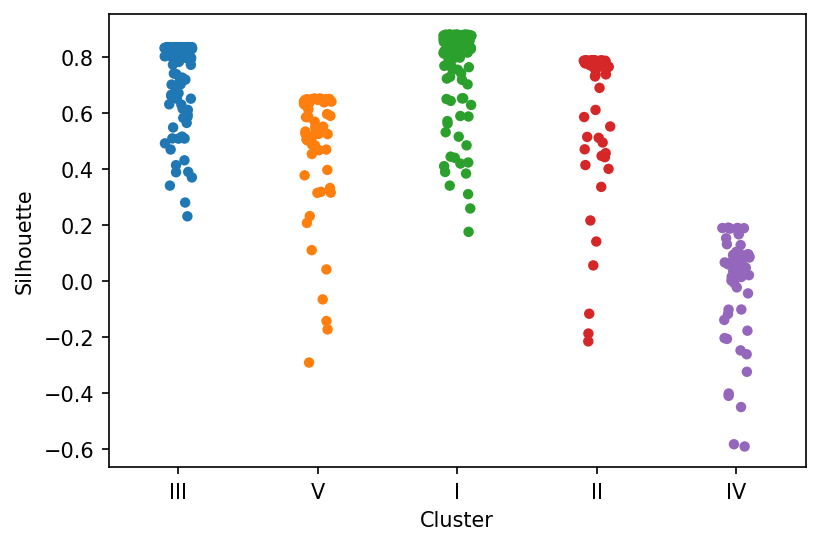

In [31]:
calcDistance = distance.pdist(counts_matrix.values, 'jensenshannon')
calcDistance[np.isnan(calcDistance)] = 0
distMat = distance.squareform(calcDistance)
silhouetteSamples = silhouette_samples(distMat, CST_Clustering['clusterID'].map(cst_string_decode_classic), metric='precomputed')

silhFrame = pds.DataFrame({'Cluster':CST_Clustering['clusterID'].map(cst_string_decode_classic), 
                           'Silhouette':silhouetteSamples})

fig, ax = plt.subplots(dpi=150)
sns.stripplot(data=silhFrame, x='Cluster', y='Silhouette', ax=ax)

fig.savefig('./Analysis Figures/VMET_16S_CSTClustering_Classic_SilhouetteSamples.png')
# fig.savefig('./Analysis Figures/VMET_16S_CSTClustering_Classic_SilhouetteSamples.eps')

## Export the CST Assignments


After obtaining the Community State Type information with hierarchical clustering, we export a dataframe containing the results 

In [9]:
CSTAssignments = pds.DataFrame({'CST_11':CST_Clustering['clusterID'].map(cst_string_decode), 
                                'CST':CST_Clustering['clusterID'].map(cst_string_decode_classic),
                                'SilhouetteValues':CST_Clustering['SilhouetteSamples']})

CSTAssignments.index = counts_matrix.index

Further to the CST classification, we specify a binary factor to discriminate samples where the vaginal microbial composition (VMC) is either dominated by Lactobacillus species (LDominant) or other species (LDepleted).

There are 2 approaches to assign samples as LDominant vs LDepleted based on VMC:

    1 - Based on the CST clusters derivded from HCA. Samples assigned to CST IV or CST VI (B. breve) are considered as "Lactobacillus Depleted". This is the main measured used in the manuscript.
    2 - Using the Relative Abundance of Lactobacillus Species counts in a microbial profile. Samples with a high proportion of Lactobacillus species counts are considered "Lactobacillus Dominant". A major limitation of this method is selection of a "good" cut-off point.


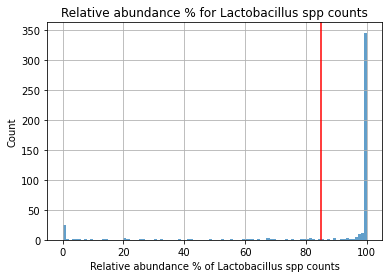

In [10]:
# Find all Lactobacilli species
Lactobacillus_Species = [x for x in counts_matrix.columns if 'Lactobacillus' in x]

# Sum their counts
lacto_counts = counts_matrix.loc[:, Lactobacillus_Species].sum(1)
total_counts = counts_matrix.sum(1)
# Calculate the lactobacillus percentage
LactobacillusPercentage = (lacto_counts/total_counts)*100
CSTAssignments['LactobacillusPercentage'] = LactobacillusPercentage

# Histogram of the Lactobacilli species % accross samples.
# 85% was a manually selected cut-off for L. Dominant vs L. Deplted by inspection of the histogram
fig, ax = plt.subplots()
CSTAssignments.hist('LactobacillusPercentage', bins=100, alpha=0.7, ax=ax)
ax.axvline(x=85, color='red')
ax.set_title('Relative abundance % for Lactobacillus spp counts')
ax.set_ylabel('Count')
ax.set_xlabel('Relative abundance % of Lactobacillus spp counts')


CSTAssignments['LDominant_CST'] = 'LDominant'
CSTAssignments['LDominant_RelAbundance'] = 'LDominant'
# All CST IV samples are lactobacillus Depleted...
CSTAssignments.loc[CSTAssignments['CST'] == 'IV', 'LDominant_CST'] = 'LDepleted'
# As well as those from the Bifidobacterium breve cluster
CSTAssignments.loc[CSTAssignments['CST'] == 'VI', 'LDominant_CST'] = 'LDepleted'

# Using the Relative Abundance Criteria, samples with a relative abundance of less than 85 % are 
CSTAssignments.loc[CSTAssignments['LactobacillusPercentage'] <= 85, 'LDominant_RelAbundance'] = 'LDepleted'


**Other Lactobacillus species**

Similarly to the VMET2 dataset, samples dominated by Lactobacillus spp other than *crispatus*, *iners*, *gasseri* or *jensenii*, such as *L. acidophilus* and *L.rhamnosus* mixed with other samples composed mainly of anaerobes and *Streptococcus*. We re-assign manually the Lactobacilli samples from this cluster to a new cluster, designated as CST 'VII', also considered to be dominated by *Lactobacillus spp*

In [11]:
other_Lactobacillus = ['Lactobacillus_delbrueckii', 'Lactobacillus_acidophilus', 'Lactobacillus_vaginalis', 'Lactobacillus_coleohominis', 'Lactobacillus_rhamnosus','Lactobacillus_paracasei'] 
counts_matrix.idxmax(1).isin(other_Lactobacillus).index

CSTAssignments.loc[counts_matrix.idxmax(1).isin(other_Lactobacillus), 'CST'] = 'VII'
# Ensure these samples are also considered Dominant per Lactobacillus
CSTAssignments.loc[counts_matrix.idxmax(1).isin(other_Lactobacillus), 'LDominant_CST'] = 'LDominant'

In [12]:
CSTAssignments.to_csv('../../Data/VMET_CSTAssignment.csv', index=True)